<a href="https://colab.research.google.com/github/harshitxjangam/Imageclass_DL/blob/main/training_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# create folder structure
!mkdir -p data models figures notebooks
!echo "Project folders created successfully ✅" && ls -l


Project folders created successfully ✅
total 20
drwxr-xr-x 2 root root 4096 Oct 15 03:29 data
drwxr-xr-x 2 root root 4096 Oct 15 03:29 figures
drwxr-xr-x 2 root root 4096 Oct 15 03:29 models
drwxr-xr-x 2 root root 4096 Oct 15 03:29 notebooks
drwxr-xr-x 1 root root 4096 Oct 13 13:43 sample_data


In [2]:
%%writefile README.md
# 🎶 Musical Instruments Image Classification

This project trains multiple deep learning models (ResNet18, MobileNetV2, ViT)
on a musical instruments dataset and explores inference optimization techniques
(TorchScript, ONNX, and INT8 quantization).


Writing README.md


In [3]:
# Check GPU
import torch, platform, sys
print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU runtime")


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA available: False
GPU name: CPU runtime


In [1]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU runtime")


CUDA available: True
GPU name: Tesla T4


In [2]:
!pip install -q kaggle torch torchvision timm onnxruntime matplotlib seaborn torchsummary
from google.colab import files
print("Upload kaggle.json from Kaggle > Account > Create New API Token")
files.upload();  # select kaggle.json
!mkdir -p ~/.kaggle && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.8 MB/s eta 0:00:00
Upload kaggle.json from Kaggle > Account > Create New API Token


Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p data
!kaggle datasets download -d nikolasgegenava/music-instruments -p ./data
!unzip -q ./data/music-instruments.zip -d ./data/musical_instruments_raw

import os
root = "./data/musical_instruments_raw"
classes = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))]
print("Found classes:", len(classes), classes[:10])


Dataset URL: https://www.kaggle.com/datasets/nikolasgegenava/music-instruments
License(s): MIT
  0% 0.00/6.21M [00:00<?, ?B/s]
100% 6.21M/6.21M [00:00<00:00, 1.04GB/s]
Found classes: 1 ['music_instruments']


In [8]:
import os, shutil, random, pathlib
from tqdm import tqdm

random.seed(42)

SRC = pathlib.Path("data/musical_instruments_raw/music_instruments")  # ✅ correct root with class folders
assert SRC.exists(), "SRC path not found; check directory."

# Clean and recreate split dirs
DST = pathlib.Path("data_split")
if DST.exists(): shutil.rmtree(DST)
for s in ["train","val","test"]:
    (DST/s).mkdir(parents=True, exist_ok=True)

classes = [d.name for d in SRC.iterdir() if d.is_dir()]
print("Detected classes:", len(classes), classes[:10])

img_exts = (".jpg",".jpeg",".png",".bmp",".gif",".webp",".tif",".tiff")
for cls in tqdm(classes, desc="Splitting"):
    files = [p for p in (SRC/cls).glob("*") if p.suffix.lower() in img_exts]
    random.shuffle(files)
    n = len(files); n_train=int(0.8*n); n_val=int(0.9*n)
    parts = {"train":files[:n_train], "val":files[n_train:n_val], "test":files[n_val:]}
    for split, items in parts.items():
        outdir = DST/split/cls
        outdir.mkdir(parents=True, exist_ok=True)
        for f in items: shutil.copy(f, outdir/f.name)

for split in ["train","val","test"]:
    total = sum(len(list((DST/split/c).glob("*"))) for c in classes)
    print(f"{split.upper()} images:", total)


Detected classes: 10 ['harmonica', 'guitar', 'banjo', 'sitar', 'tabla', 'flute', 'drum', 'violin', 'accordion', 'saxophone']


Splitting: 100%|██████████| 10/10 [00:00<00:00, 53.96it/s]

TRAIN images: 1442
VAL images: 179
TEST images: 185


In [10]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

IMG_SIZE, BATCH_SIZE = 224, 32

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder("data_split/train", transform=train_tfms)
val_ds   = datasets.ImageFolder("data_split/val",   transform=eval_tfms)
test_ds  = datasets.ImageFolder("data_split/test",  transform=eval_tfms)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds,  batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds), len(train_ds.classes), train_ds.classes[:10]


(1442,
 179,
 185,
 10,
 ['accordion',
  'banjo',
  'drum',
  'flute',
  'guitar',
  'harmonica',
  'saxophone',
  'sitar',
  'tabla',
  'violin'])

In [11]:
import os, time, torch, torch.nn as nn, torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("models", exist_ok=True); os.makedirs("figures", exist_ok=True)

def train_eval(model, train_dl, val_dl, epochs=10, lr=1e-3, name="model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)
    best_val, best_path = 0.0, f"models/{name}_best.pth"
    hist = {"train_acc":[], "val_acc":[]}

    for ep in range(1, epochs+1):
        # train
        model.train()
        correct=total=0
        for x,y in tqdm(train_dl, desc=f"[{name}] epoch {ep}/{epochs}"):
            x,y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward(); optimizer.step()
            correct += (out.argmax(1)==y).sum().item(); total += y.size(0)
        tr_acc = correct/total

        # val
        model.eval(); correct=total=0
        with torch.no_grad():
            for x,y in val_dl:
                x,y = x.to(device), y.to(device)
                out = model(x)
                correct += (out.argmax(1)==y).sum().item(); total += y.size(0)
        val_acc = correct/total

        hist["train_acc"].append(tr_acc); hist["val_acc"].append(val_acc)
        print(f"{name}: train {tr_acc:.3f} | val {val_acc:.3f}")

        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), best_path)

    # plot curves
    plt.figure()
    plt.plot(hist["train_acc"], label="train")
    plt.plot(hist["val_acc"], label="val")
    plt.title(f"{name} accuracy"); plt.xlabel("epoch"); plt.ylabel("acc"); plt.legend()
    plt.savefig(f"figures/{name}_acc.png", dpi=150); plt.show()

    print(f"Best {name} val acc: {best_val:.3f} (saved to {best_path})")
    return best_val, best_path


Model 1 - ResNet18 (transfer learning)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 114MB/s] 


[resnet18] epoch 1/10:   0%|          | 0/46 [00:00<?, ?it/s]

resnet18: train 0.432 | val 0.726


[resnet18] epoch 2/10:   0%|          | 0/46 [00:00<?, ?it/s]

resnet18: train 0.758 | val 0.827


[resnet18] epoch 3/10:   0%|          | 0/46 [00:00<?, ?it/s]

resnet18: train 0.826 | val 0.844


[resnet18] epoch 4/10:   0%|          | 0/46 [00:00<?, ?it/s]

resnet18: train 0.835 | val 0.888


[resnet18] epoch 5/10:   0%|          | 0/46 [00:00<?, ?it/s]

resnet18: train 0.856 | val 0.849


[resnet18] epoch 6/10:   0%|          | 0/46 [00:00<?, ?it/s]

resnet18: train 0.867 | val 0.855


[resnet18] epoch 7/10:   0%|          | 0/46 [00:00<?, ?it/s]

resnet18: train 0.869 | val 0.872


[resnet18] epoch 8/10:   0%|          | 0/46 [00:00<?, ?it/s]

resnet18: train 0.885 | val 0.849


[resnet18] epoch 9/10:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

resnet18: train 0.885 | val 0.872


[resnet18] epoch 10/10:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>  
 Traceback (most recent call last):
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
      ^if w.is_alive():^^
^ ^ ^  ^^^ ^ ^^^^ ^^^^^^^^^^^

resnet18: train 0.897 | val 0.877


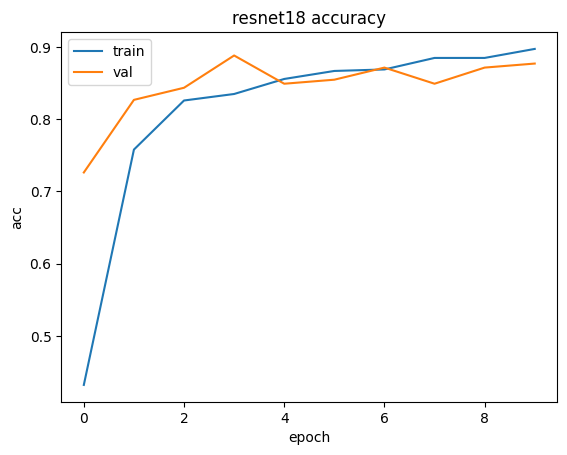

Best resnet18 val acc: 0.888 (saved to models/resnet18_best.pth)


In [12]:
from torchvision import models
from torchvision.models import ResNet18_Weights

resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# freeze backbone
for p in resnet.parameters(): p.requires_grad = False
# replace head
resnet.fc = nn.Linear(resnet.fc.in_features, len(train_ds.classes))

resnet_val, resnet_ckpt = train_eval(
    resnet, train_dl, val_dl,
    epochs=10, lr=1e-3, name="resnet18"
)


Model 2 - Model #2 — MobileNetV2 (light & fast)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 78.5MB/s]


[mobilenetv2] epoch 1/10:   0%|          | 0/46 [00:00<?, ?it/s]

mobilenetv2: train 0.719 | val 0.737


[mobilenetv2] epoch 2/10:   0%|          | 0/46 [00:00<?, ?it/s]

mobilenetv2: train 0.794 | val 0.782


[mobilenetv2] epoch 3/10:   0%|          | 0/46 [00:00<?, ?it/s]

mobilenetv2: train 0.859 | val 0.849


[mobilenetv2] epoch 4/10:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():    
     if w.is_alive(): 
 ^^^^^  ^ ^ ^ ^^  ^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^^ ^ ^ ^ 
   File "/usr/lib

mobilenetv2: train 0.890 | val 0.832


[mobilenetv2] epoch 5/10:   0%|          | 0/46 [00:00<?, ?it/s]

mobilenetv2: train 0.866 | val 0.821


[mobilenetv2] epoch 6/10:   0%|          | 0/46 [00:00<?, ?it/s]

mobilenetv2: train 0.872 | val 0.844


[mobilenetv2] epoch 7/10:   0%|          | 0/46 [00:00<?, ?it/s]

mobilenetv2: train 0.857 | val 0.760


[mobilenetv2] epoch 8/10:   0%|          | 0/46 [00:00<?, ?it/s]

mobilenetv2: train 0.901 | val 0.866


[mobilenetv2] epoch 9/10:   0%|          | 0/46 [00:00<?, ?it/s]

mobilenetv2: train 0.927 | val 0.821


[mobilenetv2] epoch 10/10:   0%|          | 0/46 [00:00<?, ?it/s]

mobilenetv2: train 0.877 | val 0.866


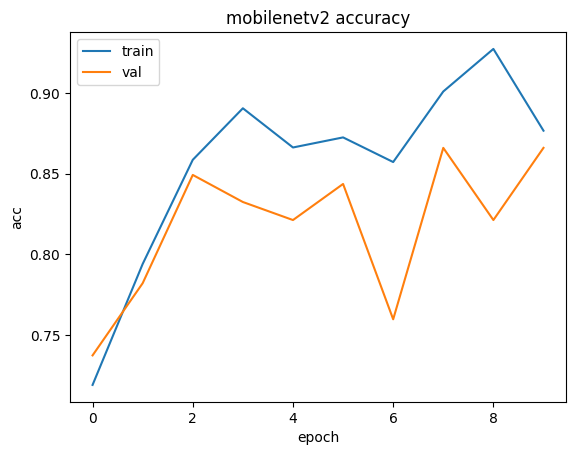

Best mobilenetv2 val acc: 0.866 (saved to models/mobilenetv2_best.pth)


In [13]:
from torchvision.models import MobileNet_V2_Weights

mobilenet = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, len(train_ds.classes))

mobilenet_val, mobilenet_ckpt = train_eval(
    mobilenet, train_dl, val_dl,
    epochs=10, lr=1e-3, name="mobilenetv2"
)


Model #3 — ViT-Tiny (from timm)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

[vit_tiny] epoch 1/10:   0%|          | 0/46 [00:00<?, ?it/s]

vit_tiny: train 0.677 | val 0.894


[vit_tiny] epoch 2/10:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
        if w.is_alive():if w.is_alive():
  
      ^^^ ^ ^ ^ ^ ^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ 
   File "/usr/lib/p

vit_tiny: train 0.942 | val 0.905


[vit_tiny] epoch 3/10:   0%|          | 0/46 [00:00<?, ?it/s]

vit_tiny: train 0.963 | val 0.933


[vit_tiny] epoch 4/10:   0%|          | 0/46 [00:00<?, ?it/s]

vit_tiny: train 0.988 | val 0.922


[vit_tiny] epoch 5/10:   0%|          | 0/46 [00:00<?, ?it/s]

vit_tiny: train 0.992 | val 0.922


[vit_tiny] epoch 6/10:   0%|          | 0/46 [00:00<?, ?it/s]

vit_tiny: train 0.997 | val 0.933


[vit_tiny] epoch 7/10:   0%|          | 0/46 [00:00<?, ?it/s]

vit_tiny: train 0.999 | val 0.883


[vit_tiny] epoch 8/10:   0%|          | 0/46 [00:00<?, ?it/s]

vit_tiny: train 0.997 | val 0.916


[vit_tiny] epoch 9/10:   0%|          | 0/46 [00:00<?, ?it/s]

vit_tiny: train 0.999 | val 0.939


[vit_tiny] epoch 10/10:   0%|          | 0/46 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300>

Traceback (most recent call last):
AssertionError:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
can only test a child process
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7871b48c9300

vit_tiny: train 0.999 | val 0.933


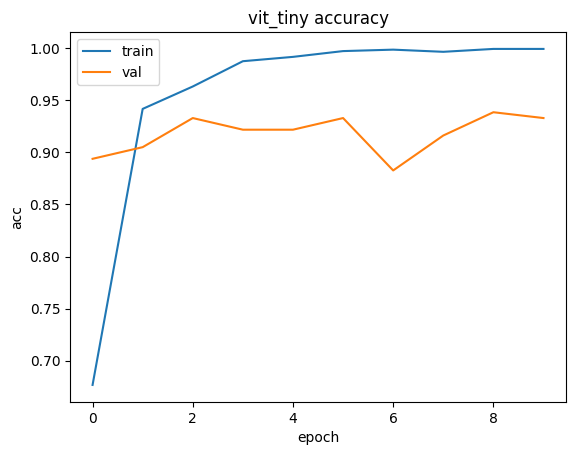

Best vit_tiny val acc: 0.939 (saved to models/vit_tiny_best.pth)


In [14]:
import timm
vit = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=len(train_ds.classes))

vit_val, vit_ckpt = train_eval(
    vit, train_dl, val_dl,
    epochs=10, lr=1e-4, name="vit_tiny"
)


Comparision Bar Chart

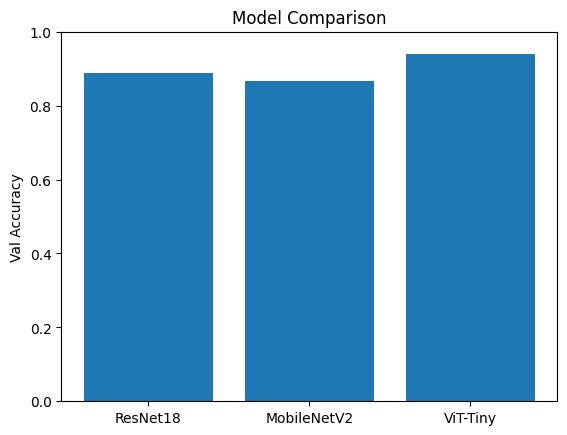

{'ResNet18': 0.888268156424581,
 'MobileNetV2': 0.8659217877094972,
 'ViT-Tiny': 0.9385474860335196}

In [15]:
import matplotlib.pyplot as plt
scores = {"ResNet18": resnet_val, "MobileNetV2": mobilenet_val, "ViT-Tiny": vit_val}
plt.figure()
plt.bar(scores.keys(), scores.values())
plt.ylim(0,1); plt.ylabel("Val Accuracy"); plt.title("Model Comparison")
plt.savefig("figures/model_val_comparison.png", dpi=150); plt.show()
scores


Test Set Evaluation

In [16]:
from torch.utils.data import DataLoader
import numpy as np

def rebuild_and_load(which):
    if which=="resnet18":
        m = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for p in m.parameters(): p.requires_grad=False
        m.fc = nn.Linear(m.fc.in_features, len(train_ds.classes))
        m.load_state_dict(torch.load(resnet_ckpt, map_location=device))
    elif which=="mobilenetv2":
        m = models.mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
        m.classifier[1] = nn.Linear(m.last_channel, len(train_ds.classes))
        m.load_state_dict(torch.load(mobilenet_ckpt, map_location=device))
    else:
        mm = timm.create_model("vit_tiny_patch16_224", pretrained=True, num_classes=len(train_ds.classes))
        mm.load_state_dict(torch.load(vit_ckpt, map_location=device))
        m = mm
    return m.to(device).eval()

def accuracy_on(loader, model):
    correct=total=0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            correct += (out.argmax(1)==y).sum().item()
            total += y.size(0)
    return correct/total

resnet_test = accuracy_on(test_dl, rebuild_and_load("resnet18"))
mobilenet_test = accuracy_on(test_dl, rebuild_and_load("mobilenetv2"))
vit_test = accuracy_on(test_dl, rebuild_and_load("vit_tiny"))

print({"ResNet18 test":resnet_test, "MobileNetV2 test":mobilenet_test, "ViT-Tiny test":vit_test})


{'ResNet18 test': 0.8972972972972973, 'MobileNetV2 test': 0.8864864864864865, 'ViT-Tiny test': 0.9459459459459459}


Baseline Inference latency

In [17]:
def avg_latency_ms(model, loader, warmup=2, batches=5):
    # warmup
    with torch.no_grad():
        it = iter(loader)
        for _ in range(warmup):
            x,_ = next(it); x = x.to(device); _ = model(x)
    if device=="cuda": torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        it = iter(loader)
        for _ in range(batches):
            x,_ = next(it); x = x.to(device); _ = model(x)
    if device=="cuda": torch.cuda.synchronize()
    return (time.time()-t0)/(batches*loader.batch_size)*1000

r = rebuild_and_load("resnet18")
m = rebuild_and_load("mobilenetv2")
v = rebuild_and_load("vit_tiny")

lat = {
    "ResNet18 FP32": avg_latency_ms(r, val_dl),
    "MobileNetV2 FP32": avg_latency_ms(m, val_dl),
    "ViT-Tiny FP32": avg_latency_ms(v, val_dl),
}
lat


{'ResNet18 FP32': 3.640472888946533,
 'MobileNetV2 FP32': 3.690621256828308,
 'ViT-Tiny FP32': 3.722551465034485}